In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

In [15]:
data_dir = "dataset"
class_names = ['carrot', 'chicken', 'corn', 'egg', 'garlic', 'lettuce', 'mushroom', 'onion', 'potato', 'salmon', 'shrimp', 'tomato']
batch_size = 64
num_epochs = 20
learning_rate = 0.001
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [10]:
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/20], Train Loss: 0.6839, Val Loss: 0.7195, Acc: 81.67%, Time: 60.41s
Epoch [2/20], Train Loss: 0.2934, Val Loss: 0.4473, Acc: 85.00%, Time: 54.39s
Epoch [3/20], Train Loss: 0.1395, Val Loss: 0.7592, Acc: 77.67%, Time: 54.82s
Epoch [4/20], Train Loss: 0.1813, Val Loss: 0.3220, Acc: 90.08%, Time: 55.45s
Epoch [5/20], Train Loss: 0.1582, Val Loss: 0.2429, Acc: 92.67%, Time: 57.37s
Epoch [6/20], Train Loss: 0.0854, Val Loss: 0.1741, Acc: 93.75%, Time: 54.52s
Epoch [7/20], Train Loss: 0.0568, Val Loss: 0.3605, Acc: 89.67%, Time: 54.37s
Epoch [8/20], Train Loss: 0.0642, Val Loss: 0.3314, Acc: 91.17%, Time: 54.89s
Epoch [9/20], Train Loss: 0.0746, Val Loss: 0.4241, Acc: 88.08%, Time: 55.03s
Epoch [10/20], Train Loss: 0.0758, Val Loss: 0.3542, Acc: 90.50%, Time: 54.44s
Epoch [11/20], Train Loss: 0.0636, Val Loss: 0.3359, Acc: 91.25%, Time: 54.57s
Epoch [12/20], Train Loss: 0.0409, Val Loss: 0.1143, Acc: 95.75%, Time: 55.56s
Epoch [13/20], Train Loss: 0.0113, Val Loss: 0.0686, Acc: 97.

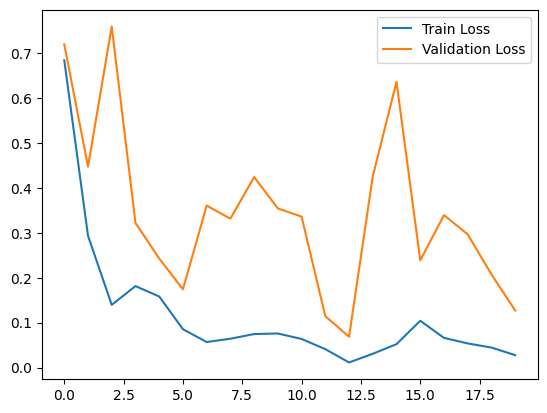

NameError: name 'class_names' is not defined

In [ ]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    start = time.time()

    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {accuracy:.2f}%, "
          f"Time: {time.time()-start:.2f}s")

torch.save(model.state_dict(), "ingredient_classifier2.pth")
print("Model has been saved as ingredient_classifier2.pth")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

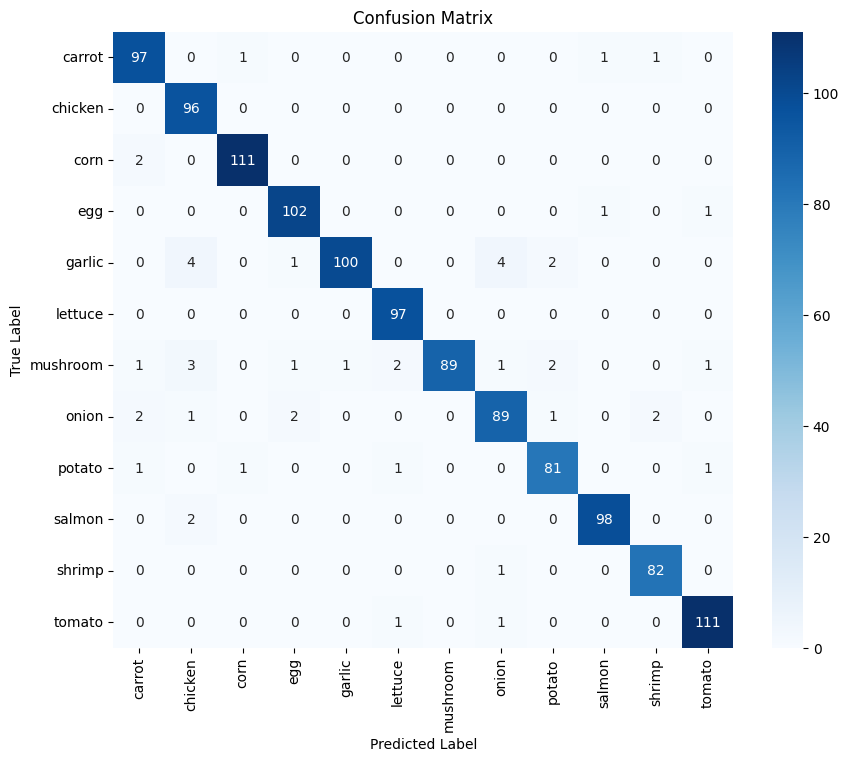

Classification Report:
              precision    recall  f1-score   support

      carrot       0.94      0.97      0.96       100
     chicken       0.91      1.00      0.95        96
        corn       0.98      0.98      0.98       113
         egg       0.96      0.98      0.97       104
      garlic       0.99      0.90      0.94       111
     lettuce       0.96      1.00      0.98        97
    mushroom       1.00      0.88      0.94       101
       onion       0.93      0.92      0.92        97
      potato       0.94      0.95      0.95        85
      salmon       0.98      0.98      0.98       100
      shrimp       0.96      0.99      0.98        83
      tomato       0.97      0.98      0.98       113

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



In [16]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
